In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
from numpy.fft import fft, rfft
np.seterr(divide = 'ignore') 

from .fingerprint import generate_spectrogram, plot_spectrogram, generate_fingerprints_from_spectrogram
import settings

## Testing the fingerprint functions

In [2]:
path = "test.wav"
sample_rate_hz, audio_data = scipy.io.wavfile.read(path)
audio_data = np.mean(audio_data, axis=1) # convert stereo to mono
print(sample_rate_hz)

44100


In [4]:
spectrogram, frequencies = generate_spectrogram(sample_rate_hz=sample_rate_hz, audio_data=audio_data)
plot_spectrogram(spectrogram=spectrogram, hop_size=settings.HOP_SIZE, sample_rate_hz=sample_rate_hz)

In [7]:
magnitudes = spectrogram.T[0]
assert len(frequencies) == len(magnitudes)
freqs_mags = sorted(list(zip(frequencies, magnitudes)), key=lambda x: x[0])

In [8]:
frame_fingerprints = []

for lower, upper in settings.FREQUENCY_BUCKETS_FOR_FINGERPRINTS:
    bucket_freqs_mags = [(freq, mag) for (freq, mag) in freqs_mags if lower <= freq <= upper]
    if len(bucket_freqs_mags) == 0: continue
    frame_fingerprints.append(sorted(bucket_freqs_mags, key=lambda x: x[1], reverse=True)[0][0])

print(frame_fingerprints)

[43.06640625, 86.1328125, 129.19921875, 290.6982421875, 301.46484375, 699.8291015625, 1001.2939453125, 1313.525390625]


In [10]:
fingerprints = generate_fingerprints_from_spectrogram(spectrogram=spectrogram, frequencies=frequencies, sampling_rate_hz=sample_rate_hz)
fingerprints

['438612929030169910011313',
 '43861291833015068071205',
 '43861291833016138501324',
 '53961291833226358181324',
 '431181292793125069901528',
 '5311813925837652710551571',
 '7511812925838752710441571',
 '649612925834452710441571',
 '539612925837651610441561',
 '539613925831252710441571',
 '6411812922643052710551571',
 '5310715020434452710441571',
 '7511817220443051610441561',
 '7511813926936658111731754',
 '5311813926938758111621754',
 '5311812925831258111731754',
 '5310713925834458111731765',
 '6411812926943058111841561',
 '531181292904096898291561',
 '43961392474096898291388',
 '751071722904096998181388',
 '4311812929040969910441399',
 '7511817229040969910331388',
 '531181722904095818181388',
 '641181502264095818181388',
 '531181292263446998181399',
 '531181722364096998181399',
 '531181292363445818291399',
 '53961292363446358721238',
 '531181722903446358611388',
 '751071292903445278071388',
 '5310713924740968910331399',
 '7511813929040969910441399',
 '4310712929040968910441399',
 '43

## Recognition

In [11]:
import csv, sys
csv.field_size_limit(sys.maxsize)

database = []

def load_database():
    with open(settings.FINGERPRINTS_DATABASE_PATH, 'r') as f:
        reader = csv.reader(f)
        fingerprints_database = list(reader)

    for track in fingerprints_database:
        track_id = track[0]
        fingerprints = track[1].split(" ")
        for i, fingerprint in enumerate(fingerprints):
            timestamp = i * settings.HOP_SIZE / sample_rate_hz
            database.append((track_id, fingerprint, timestamp))
load_database()

In [14]:
import random
from recognition_utils import truncate_audio_to_seconds_length, recognise_audio

# Fix the seed for the random truncation
random.seed(42)
audio_to_recognise = truncate_audio_to_seconds_length(audio_data, seconds=20)

# Recognise the audio - result will change each time you run this cell unless the seed is fixed
recognise_audio(audio_to_recognise, database)

('Eddies_Twister', 0.7762237762237763)

Now, we try to make recognition more challenging, by adding random Gaussian noise to the input audio

In [16]:
from recognition_utils import add_random_noise

random.seed(42)
noisy_audio = add_random_noise(audio_to_recognise, (4))
recognise_audio(noisy_audio)

Mean noise level: 2524.732588435374


('Eddies_Twister', 0.14285714285714285)

In [17]:
import IPython
IPython.display.Audio(noisy_audio, rate=sample_rate_hz)

# Final testing

We will test the recognition systems by varying two factors: the length of audio clips and the level of Gaussian noise added to them.

We shall test 7 different values for each of these respectively, giving us 49 total settings to test. We shall apply these settings to the entire audio library and record the performance of the recogniser for each setting.

In [18]:
# Quick sanity check for the 0 noise setting - should not change the audio
random.seed(42)
add_random_noise(audio_to_recognise, 0).shape
np.testing.assert_array_equal(add_random_noise(audio_to_recognise, 0), audio_to_recognise)

In [3]:
# Generate all the setting permutations
permutations = []
for clip_length in settings.CLIP_LENGTHS:
    for noise_level in settings.NOISE_LEVELS:
        permutations.append((clip_length, noise_level))
permutations

[(0.1, 0.0),
 (0.1, 0.5),
 (0.1, 1.0),
 (0.1, 2.5),
 (0.1, 5.0),
 (0.1, 7.5),
 (0.1, 10.0),
 (0.5, 0.0),
 (0.5, 0.5),
 (0.5, 1.0),
 (0.5, 2.5),
 (0.5, 5.0),
 (0.5, 7.5),
 (0.5, 10.0),
 (1, 0.0),
 (1, 0.5),
 (1, 1.0),
 (1, 2.5),
 (1, 5.0),
 (1, 7.5),
 (1, 10.0),
 (2.5, 0.0),
 (2.5, 0.5),
 (2.5, 1.0),
 (2.5, 2.5),
 (2.5, 5.0),
 (2.5, 7.5),
 (2.5, 10.0),
 (5, 0.0),
 (5, 0.5),
 (5, 1.0),
 (5, 2.5),
 (5, 5.0),
 (5, 7.5),
 (5, 10.0),
 (7.5, 0.0),
 (7.5, 0.5),
 (7.5, 1.0),
 (7.5, 2.5),
 (7.5, 5.0),
 (7.5, 7.5),
 (7.5, 10.0),
 (10.0, 0.0),
 (10.0, 0.5),
 (10.0, 1.0),
 (10.0, 2.5),
 (10.0, 5.0),
 (10.0, 7.5),
 (10.0, 10.0)]

In [29]:
# Load the tracks into memory
track_ids = []
paths = []
with open("tracks_database.csv", 'r') as f:
    reader = csv.reader(f)
    tracks_database = list(reader)
    track_ids = [row[0] for row in tracks_database]

In [30]:
# Run the test and save the results

random.seed(42)

results = []

for permutation in permutations:
    clip_length, noise_level = permutation
    print(f"Testing {clip_length=} with {noise_level=}")
    
    for track_id in track_ids:
        path = f"recordings/{track_id}.wav"
        sample_rate_hz, audio_data = scipy.io.wavfile.read(path)
        if len(audio_data.shape) > 1:
            audio_data = np.mean(audio_data, axis=1)

        audio_data = truncate_audio_to_seconds_length(audio_data, clip_length)
        audio_data = add_random_noise(audio_data, noise_level)

        result_id, confidence = recognise_audio(audio_data)
        is_correct = track_id == result_id
        result = (clip_length, noise_level, track_id, result_id, confidence, is_correct)
        print(f'{result=}')
        results.append(result)

Testing clip_length=0.1 with noise_level=0.0
result=(0.1, 0.0, 'Ommie_Wise_by_G_B_Grayson', 'Ommie_Wise_by_G_B_Grayson', 1.0, True)
result=(0.1, 0.0, 'Oi_ya_nestchastay', None, 0, False)
result=(0.1, 0.0, 'In_The_Dark_Flashes', None, 0, False)
result=(0.1, 0.0, 'Umbrellas_To_Mend', None, 0, False)
result=(0.1, 0.0, 'Titanic_Blues', 'House_Carpenter_by_William_Edens', 0.5, False)
result=(0.1, 0.0, '55_By_Beatrice_Dillon', None, 0, False)
result=(0.1, 0.0, 'Peg_And_Awl_by_The_Carolina_Tar_Heels', None, 0, False)
result=(0.1, 0.0, 'April_Kisses', None, 0, False)
result=(0.1, 0.0, 'John_Hardy_By_Karen_Gwyer', None, 0, False)
result=(0.1, 0.0, 'Night_Latch_Key_Blues', 'Night_Latch_Key_Blues', 1.0, True)
result=(0.1, 0.0, 'Dry_Bones_by_Bascom_Lamar_Lunsford', None, 0, False)
result=(0.1, 0.0, 'ATL_BEAT_10', 'ATL_BEAT_10', 0.125, True)
result=(0.1, 0.0, 'Ole_Gray_Beard_By_Karen_Gwyer', None, 0, False)
result=(0.1, 0.0, 'Jump_Steady_Blues', 'Jump_Steady_Blues', 1.0, True)
result=(0.1, 0.0, 'My

In [31]:
# Convert the results into accuracy percentages
accuracies = []

for clip_length in settings.CLIP_LENGTHS:
    clip_length_accuracies = []
    for noise_level in reversed(settings.NOISE_LEVELS):
        results_for_permutation = [result for result in results if result[0] == clip_length and result[1] == noise_level]
        fraction_correct = sum([result[-1] for result in results_for_permutation]) / len(results_for_permutation)
        print(f'{clip_length=} {noise_level=} {fraction_correct*100}%')
        clip_length_accuracies.append(fraction_correct)
    accuracies.append(clip_length_accuracies)

clip_length=0.1 noise_level=10.0 0.0%
clip_length=0.1 noise_level=7.5 0.0%
clip_length=0.1 noise_level=5.0 0.0%
clip_length=0.1 noise_level=2.5 1.5625%
clip_length=0.1 noise_level=1.0 4.6875%
clip_length=0.1 noise_level=0.5 6.25%
clip_length=0.1 noise_level=0.0 23.4375%
clip_length=0.5 noise_level=10.0 0.0%
clip_length=0.5 noise_level=7.5 0.0%
clip_length=0.5 noise_level=5.0 12.5%
clip_length=0.5 noise_level=2.5 4.6875%
clip_length=0.5 noise_level=1.0 31.25%
clip_length=0.5 noise_level=0.5 43.75%
clip_length=0.5 noise_level=0.0 73.4375%
clip_length=1 noise_level=10.0 0.0%
clip_length=1 noise_level=7.5 0.0%
clip_length=1 noise_level=5.0 15.625%
clip_length=1 noise_level=2.5 18.75%
clip_length=1 noise_level=1.0 45.3125%
clip_length=1 noise_level=0.5 59.375%
clip_length=1 noise_level=0.0 82.8125%
clip_length=2.5 noise_level=10.0 3.125%
clip_length=2.5 noise_level=7.5 3.125%
clip_length=2.5 noise_level=5.0 4.6875%
clip_length=2.5 noise_level=2.5 31.25%
clip_length=2.5 noise_level=1.0 70.31

In [32]:
accuracies

[[0.0, 0.0, 0.0, 0.015625, 0.046875, 0.0625, 0.234375],
 [0.0, 0.0, 0.125, 0.046875, 0.3125, 0.4375, 0.734375],
 [0.0, 0.0, 0.15625, 0.1875, 0.453125, 0.59375, 0.828125],
 [0.03125, 0.03125, 0.046875, 0.3125, 0.703125, 0.765625, 0.9375],
 [0.0, 0.015625, 0.171875, 0.375, 0.65625, 0.921875, 0.9375],
 [0.03125, 0.046875, 0.21875, 0.4375, 0.765625, 0.859375, 0.96875],
 [0.015625, 0.09375, 0.328125, 0.453125, 0.828125, 0.9375, 0.96875]]

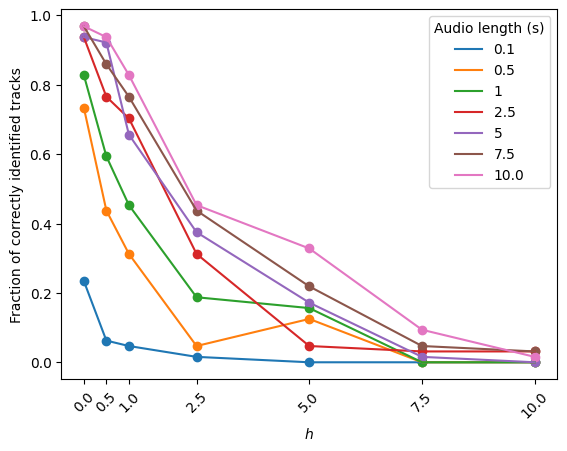

In [8]:
for i in range(len(accuracies)):
    plt.scatter(list(reversed(settings.NOISE_LEVELS)), accuracies[i], label='_nolegend_')
    plt.plot(list(reversed(settings.NOISE_LEVELS)), accuracies[i])

plt.legend(settings.CLIP_LENGTHS)
plt.gca().get_legend().set_title('Audio length (s)')
plt.xlabel('$h$')
plt.ylabel('Fraction of correctly identified tracks')
plt.xticks(settings.NOISE_LEVELS)
plt.xticks(rotation=45)
plt.savefig('./figs/accuracy-of-recogniser.png', dpi=300)

In [15]:
table = """"""
for i, accuracy_set in enumerate(accuracies):
    table_row = f"{settings.CLIP_LENGTHS[i]} & " + " & ".join([f"{round(accuracy * 100, 3)}" for accuracy in accuracy_set]) + r" \\"
    table += table_row + "\n"
print(table)

0.1 & 0.0 & 0.0 & 0.0 & 1.562 & 4.688 & 6.25 & 23.438 \\
0.5 & 0.0 & 0.0 & 12.5 & 4.688 & 31.25 & 43.75 & 73.438 \\
1 & 0.0 & 0.0 & 15.625 & 18.75 & 45.312 & 59.375 & 82.812 \\
2.5 & 3.125 & 3.125 & 4.688 & 31.25 & 70.312 & 76.562 & 93.75 \\
5 & 0.0 & 1.562 & 17.188 & 37.5 & 65.625 & 92.188 & 93.75 \\
7.5 & 3.125 & 4.688 & 21.875 & 43.75 & 76.562 & 85.938 & 96.875 \\
10.0 & 1.562 & 9.375 & 32.812 & 45.312 & 82.812 & 93.75 & 96.875 \\

